# Watermark Detection


## 1. Setup

In [41]:
from tqdm import tqdm 

import os
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
try:
    import torch_xla.core.xla_model as xm
except ImportError:
    xm = None

import torchvision
import numpy as np

%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = xm.xla_device()

print(device)

mps


## 2. Visualize Data

In [55]:
TRAIN_MEAN = [140.562, 133.033, 124.148] 
TRAIN_STD = [60.562, 61.536, 65.176]

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(TRAIN_MEAN, TRAIN_STD)
])

dataset_train = torchvision.datasets.ImageFolder(root='dataset/train', transform=transforms)
dataloader_train = DataLoader(dataset_train, batch_size=4, shuffle=True)

In [65]:
from project.utils.data_transforms import NormilizeInverse

def imshow(img, ax, mean=TRAIN_MEAN, std=TRAIN_STD):
    unormalize = NormilizeInverse(mean, std)
    img = unormalize(img)
    np_img = img.numpy()
    ax.imshow(np.transpose(np_img, (1, 2, 0)))

dataiter = iter(dataloader_train)
for images, labels in dataiter:
    break

# imshow(torchvision.utils.make_grid(images))

In [73]:
idx_to_class = {idx : c for c, idx in dataset_train.class_to_idx.items()}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


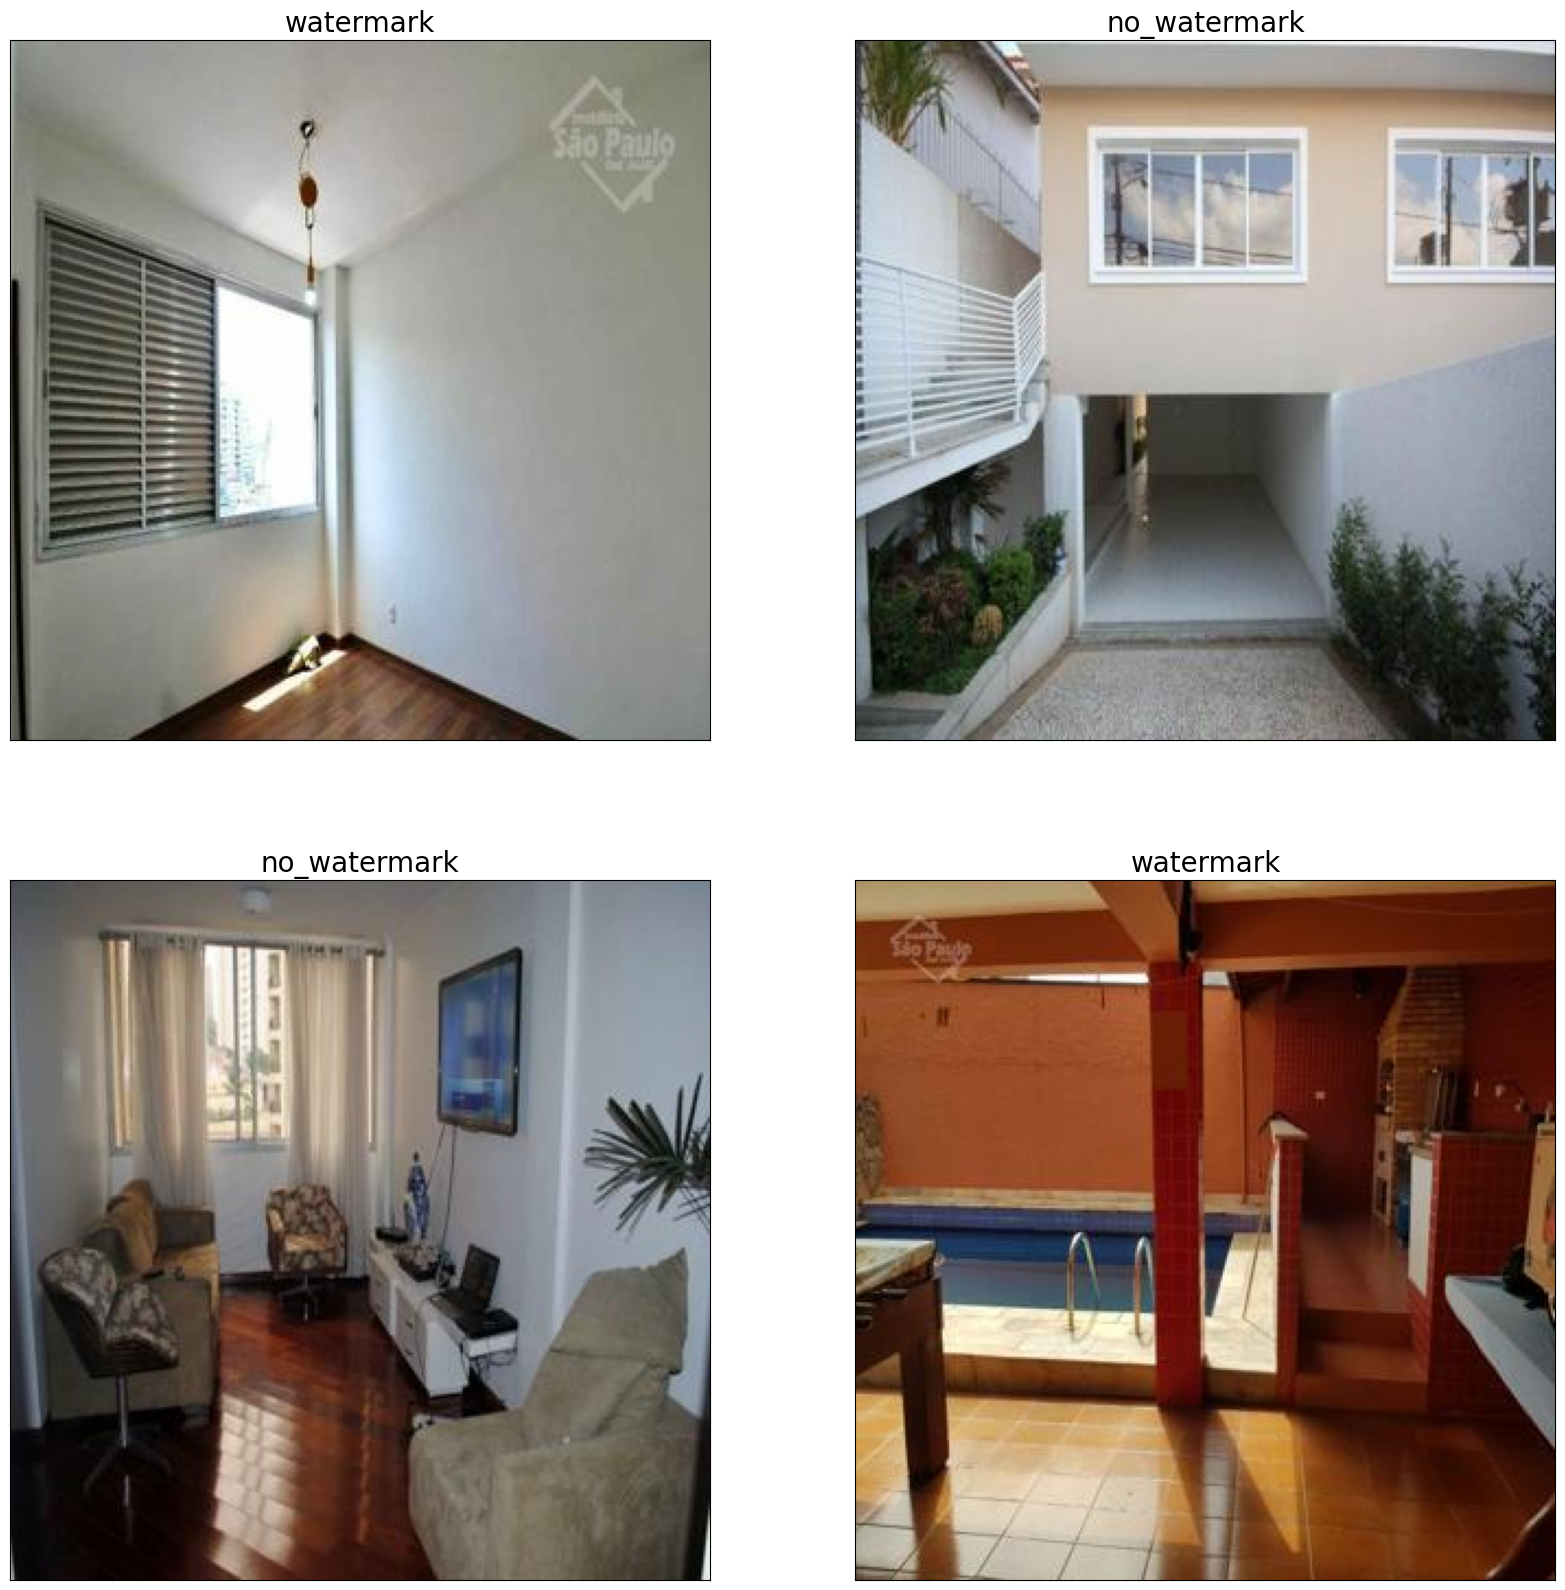

In [79]:
fig = plt.figure(figsize=(20,20))

for idx in range(4):
    ax = fig.add_subplot(2, 2, idx+1, xticks=[], yticks=[])
    imshow(images[idx], ax)
    ax.set_title(idx_to_class[int(labels[idx])], fontdict={'fontsize': 20})